# Прогнозирование вероятности дефолта заемщика
## Описание задачи
Построить модель для предсказания дефолта клиента.

### Описание датасета по условиям задачи

Переменные, которые содержит датасет:
1. client_id - идентификатор клиента
2. education - уровень образования (SCH - школьное образование, UGR - бакалавриат, GRD - магистратура, PGR - дополнительные программы после бакалавриата и ACD - научные степени (кандидат, доктор))
3. sex - пол заемщика
4. age - возраст заемщика
5. car - флаг наличия автомобиля
6. car_type - флаг автомобиля-иномарки
7. decline_app_cnt - количество отказанных прошлых заявок
8. good_work - флаг наличия “хорошей” работы
9. bki_request_cnt - количество запросов в БКИ
10. home_address - категоризатор домашнего адреса
11. work_address - категоризатор рабочего адреса
12. income - доход заемщика
13. foreign_passport - наличие загранпаспорта
14. sna - связь заемщика с клиентами банка
15. first_time - давность наличия информации о заемщике
16. score_bki - скоринговый балл по данным из БКИ
17. region_rating - рейтинг региона
18. app_date - дата подачи заявки
19. default - наличие дефолта по кредиту

# Загрузка необходимых библиотек и функций¶

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
from numpy import mean

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline


from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold, SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from IPython.core.display import display, HTML

from scipy.stats import randint
import statsmodels.api as sm

from math import log as log
import os

from itertools import combinations
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_columns', None)

### Классы и Функции

In [3]:
label_encoder = LabelEncoder()
scaler_st = StandardScaler()
scaler_rb = RobustScaler()

In [4]:
def get_boxplot(df, column):
    '''Функция для построения boxplot'''
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score_bki',
                data=df,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [5]:
def get_stat_dif(column, data):
    '''Функция для нахождения статистической разницы для бинарных и категориальных признаков'''
    cols = data.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'default'],
                     data.loc[train_df.loc[:, column] == comb[1], 'default']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [6]:
class LogDf(): # класс логарифмирования признака
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 


class NumFitInspect(): # класс для построения визуализация для числового признака и нахождения выбросов.
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False): # графики
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))

        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax1) # сравнение с нормальным распределением
        fig.suptitle('QQ-plot, histogram and boxplot for {0} '.format(column))
        
        ax2.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'green') # гистограмма
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def boundaries(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def outliers(self, log = False): # общее количество выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.boundaries(log)
        return len(data[data < minb])+ len(data[data > maxb])

In [7]:
# Класс-помощник для красивого отображения данных о модели
class ModelInspector():
    def __init__(self, model, X, y):
        self.model = model
        self.X = X
        self.y = y

    def _plot_confusion_matrix(self, y_pred, ax):
        tn, fp, fn, tp = confusion_matrix(self.y, y_pred).ravel()

        matrix = np.eye(2)
        matrix_annot = [[f'TP\n{tp}', f'FP\n{fp}'], [f'FN\n{fn}', f'TN\n{tn}']]

        sns.heatmap(matrix, annot=matrix_annot, annot_kws={"size": 20}, fmt='', cmap='Greens', cbar=False,
                    xticklabels=['', 'Good client'], yticklabels=['Bad client', ''], ax=ax)

    def _plot_metrics(self, y_pred, roc_auc, ax):
        matrix = np.array([[1, 0, 1, 0, 1]]).T

        matrix_annot = np.array([[
            f'ROC AUC: {roc_auc:.4f}',
            f'Balanced accuracy: {balanced_accuracy_score(self.y, y_pred):.3f}',
            f'F1-score: {f1_score(self.y, y_pred):.3f}',
            f'Precision score: {precision_score(self.y, y_pred):.3f}',
            f'Recall score: {recall_score(self.y, y_pred):.3f}'
        ]]).T

        sns.heatmap(matrix, annot=matrix_annot, fmt='', cbar=False, yticklabels=[],
                    xticklabels=[], annot_kws={'size': 16, 'ha': 'center'}, cmap='GnBu', ax=ax)

    def _plot_logistic_regression(self, probs, ax):
        fpr, tpr, threshold = roc_curve(self.y, probs)

        ax.plot([0, 1], label='Baseline', linestyle='--')
        ax.plot(fpr, tpr, label='Regression')
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.legend(loc='lower right')

    def inspect(self, size=5):
        y_pred = self.model.predict(self.X)
        probs = self.model.predict_proba(self.X)[:, 1]
        roc_auc = roc_auc_score(self.y, probs)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3*size, size))

        fig.suptitle(f'Model inspection. ROC AUC: {roc_auc:.4f}', fontsize=20)

        ax1.set_title('Logistic Regression')
        ax2.set_title('Confusion matrix')
        ax3.set_title('Metrics')

        # Plot logistic regression
        self._plot_logistic_regression(probs, ax1)

        # Plot confusion matrix
        self._plot_confusion_matrix(y_pred, ax2)

        # plot metrics
        self._plot_metrics(y_pred, roc_auc, ax3)

        plt.show()

In [8]:
def get_model(X, y):
    '''Функция для построения модели и определения метрик.'''
    
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    
    ModelInspector(model, X, y).inspect()

## Осмотр и предварительный анализ данных

In [9]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [12]:
print('Размерность тренировочного датасета: ', train_df.shape, '\n')
print('Размерность тестовго датасета: ', test_df.shape)

Размерность тренировочного датасета:  (73799, 19) 

Размерность тестовго датасета:  (36349, 18)


In [13]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
train_df['Train'] = 1 # помечаем где у нас трейн
test_df['Train'] = 0 # помечаем где у нас тест

data = test_df.append(train_df, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [15]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
Train                   0
default             36349
dtype: int64

In [16]:
data.education.describe()

count     109670
unique         5
top          SCH
freq       57998
Name: education, dtype: object

In [17]:
data.describe(include = 'object')

,app_date,education,sex,car,car_type,foreign_passport
count,110148,109670,110148,110148,110148,110148
unique,120,5,2,2,2,2
top,18MAR2014,SCH,F,N,N,N
freq,1491,57998,61836,74290,89140,93721


In [18]:
# Посмотрим на значения в строковых полях
cols = data.columns
for col in cols:
    if data[col].dtype == 'O':
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))

Уникальные значения в поле app_date : ['22MAR2014' '24JAN2014' '23MAR2014' '03FEB2014' '04FEB2014' '17APR2014'
 '02FEB2014' '28MAR2014' '23JAN2014' '24APR2014' '25FEB2014' '15JAN2014'
 '13APR2014' '12MAR2014' '17MAR2014' '01FEB2014' '15FEB2014' '01APR2014'
 '20FEB2014' '20APR2014' '27JAN2014' '24FEB2014' '18JAN2014' '16JAN2014'
 '13FEB2014' '02APR2014' '07MAR2014' '08APR2014' '21FEB2014' '16MAR2014'
 '08JAN2014' '24MAR2014' '19MAR2014' '19JAN2014' '18APR2014' '05APR2014'
 '25MAR2014' '06MAR2014' '29APR2014' '28APR2014' '22JAN2014' '27MAR2014'
 '31JAN2014' '11JAN2014' '22FEB2014' '05FEB2014' '07APR2014' '14MAR2014'
 '06APR2014' '02MAR2014' '06JAN2014' '05MAR2014' '10MAR2014' '22APR2014'
 '26FEB2014' '16FEB2014' '01MAR2014' '04JAN2014' '30JAN2014' '09FEB2014'
 '11FEB2014' '04MAR2014' '29JAN2014' '04APR2014' '25APR2014' '19FEB2014'
 '14FEB2014' '26MAR2014' '13JAN2014' '18MAR2014' '06FEB2014' '03MAR2014'
 '23APR2014' '18FEB2014' '20JAN2014' '23FEB2014' '31MAR2014' '08FEB2014'
 '03APR2014' 

In [19]:
# Посмотрим на числовые признаки
cols = data.columns
for col in cols:
    if data[col].dtype != 'O' and len(data[col].unique())<=20:
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))

Уникальные значения в поле good_work : [0 1]
Уникальные значения в поле region_rating : [50 40 80 60 70 20 30]
Уникальные значения в поле home_address : [1 2 3]
Уникальные значения в поле work_address : [2 3 1]
Уникальные значения в поле sna : [1 4 2 3]
Уникальные значения в поле first_time : [4 3 1 2]
Уникальные значения в поле Train : [0 1]
Уникальные значения в поле default : [nan  0.  1.]


Данные - "чистые", опечаток и ошибок на первый взгляд в них нет.

In [20]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,Train,default
9776,1464,06JAN2014,SCH,M,24,N,N,0,0,-1.263400,4,50,2,2,35000,2,3,N,0,NaN
22493,43673,20FEB2014,SCH,M,35,Y,Y,0,0,-2.221059,2,50,1,2,22000,1,2,N,0,NaN
93406,43382,19FEB2014,SCH,F,52,N,N,1,0,-0.414401,2,60,2,3,11000,1,2,N,1,1.0
1052,57145,05MAR2014,SCH,F,48,N,N,0,0,-1.593040,2,40,2,2,15000,1,4,N,0,NaN
9947,191,02JAN2014,SCH,F,39,Y,N,2,0,-2.747901,1,60,1,1,150000,1,3,N,0,NaN


# Осмотр признаков

Посмотрим повнимательнее на распределение признаков в зависимости от целевой переменной, сделаем минимальную предобработку данных. Начнём с того, что распределим имеющиеся признаки в три категори: числовые, бинарные и категориальные.

In [21]:
bin_cols = ['sex', 'good_work', 'foreign_passport', 'car', 'car_type']
cat_cols = ['education', 'region_rating', 'home_address', 'sna', 'first_time', 'work_address']
num_cols = ['age', 'income', 'score_bki', 'bki_request_cnt', 'decline_app_cnt']

## bin_cols

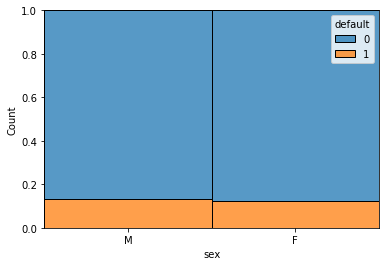

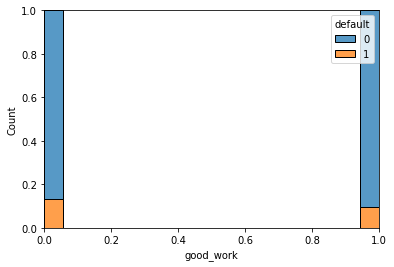

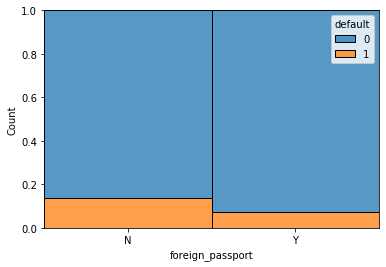

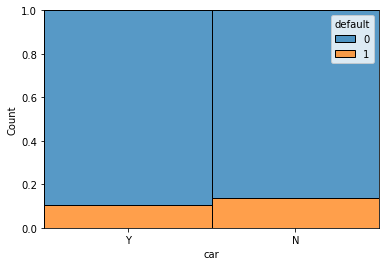

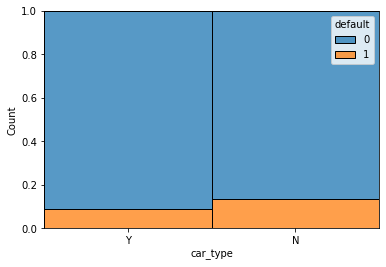

In [22]:
for col in bin_cols:
    sns.histplot(train_df, x=col, hue='default', stat='count', multiple='fill')
    plt.show()

### Таким образом, дефолтными клиентами чаще становятся:
1. Мужчины (хотя разница незначительна).
2. Люди, не имеющие флага "хорошая работа".
3. Люди, не имеющие заграничного паспорта и автомобиля, при этом в случае наличия авто - чаще всего он НЕ является иномаркой.
Подобное распределение абсолютно понятно и объяснимо, так как эти признаки (за исключением пола свидетельствуют об уровне жизни и материальном достатке заемщика.

Переведем данные признаки в числовые, посмотрим их значимость, а также корреляцию.

In [23]:
for column in bin_cols:
    train_df[column] = label_encoder.fit_transform(train_df[column])

train_df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
18034,35907,12FEB2014,SCH,1,49,1,1,0,0,-2.136937,1,60,2,3,24000,4,1,0,0,1
67236,13862,21JAN2014,GRD,0,27,1,1,0,0,-1.396717,0,50,1,1,300000,1,4,1,0,1
17351,3220,09JAN2014,SCH,1,65,0,0,0,1,-2.096733,2,50,1,3,75000,1,4,0,0,1
64233,17398,24JAN2014,SCH,0,45,0,0,0,1,-1.887366,5,50,2,3,25000,2,2,0,1,1
16326,43607,20FEB2014,SCH,0,48,0,0,1,0,-2.301723,4,60,2,3,30000,1,4,0,0,1


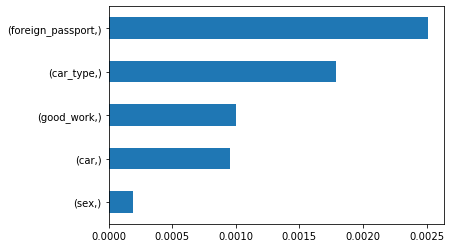

In [24]:
# Посмотрим значимость признаков
imp_bin = Series(mutual_info_classif(train_df[bin_cols], train_df['default'], 
                                     discrete_features=True), index=[bin_cols])
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')

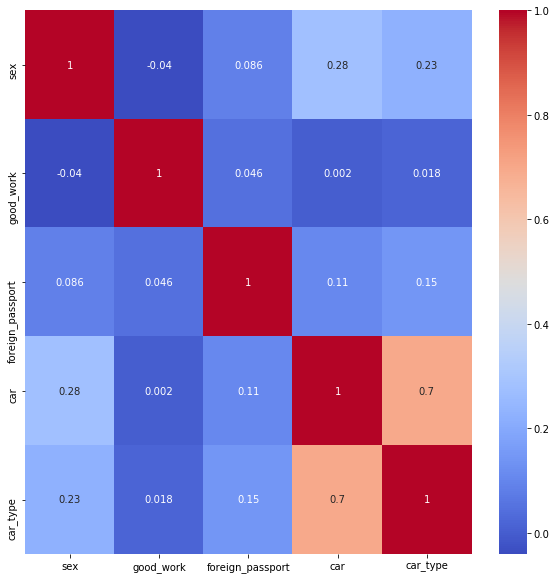

In [25]:
# Построим корреляционную матрицу
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_df[bin_cols].corr(), 
                 annot=True, cmap='coolwarm')

### Выводы по бинарным признакам:
1. Пол практически не имеет значения для модели. 
2. Самый важный признак - наличие заграничного паспорта, что с наибольшей вероятностью может говорить о возможности человека посещать заграничные страны и его высоком материальном достатке. 
3. Признаки car и car_type имеют большую корреляцию.
4. Вид автомобиля является более важным для модели нежели само наличие автомобиля, так как иномарка свидетельствует о более выосоком доходе её владельца недели отечественное авто. 

В последующей обработке можно будет попробовать два скоррелированных признака объединить в один категориальный, в таком случае у нас будет 0 - отсутствие авто, 1 - наличие отечественного авто, 2 - наличие иномарки. Такой подход может помочь в борьбе с мультиколлинеарностью.

## cat_cols

В категориальных данных у нас все признаки зашифрованы в цифры кроме образования. Давайте переведем его в цифровое обозначение и далее посмотрим пропорции, зависимости и корреляции.

In [26]:
edu = {'SCH' : 1, 'UGR' : 2, 'GRD' : 3, 'PGR' : 4, 'ACD' : 5}

train_df.education = train_df.education.map(edu)

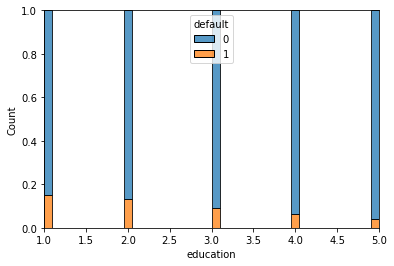

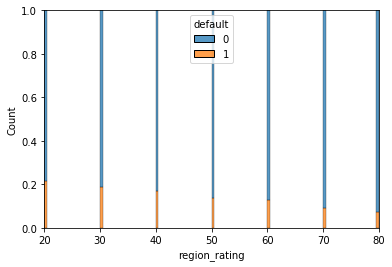

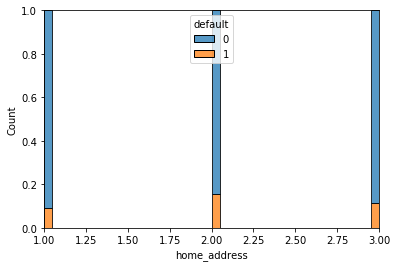

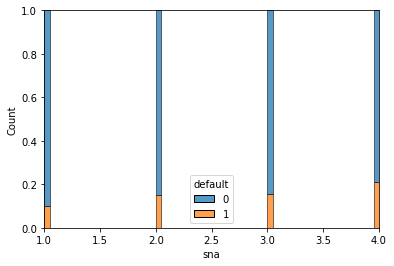

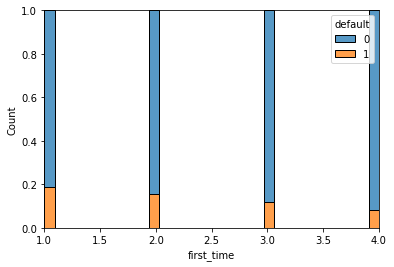

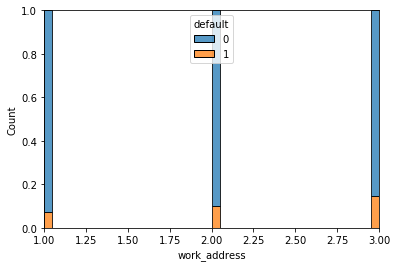

In [27]:
# посмотрим пропорцию с учетом дефолта
for col in cat_cols:
    sns.histplot(train_df, x=col, hue='default', stat='count', multiple='fill')
    plt.show()

### Таким образом, дефолтными клиентами чаще становятся:
1) Люди с низким уровнем образования.
2) Люди, проживающие на территории регионов низким рейтингом, то есть экономически менее развитых и скорее всего с низкими уровнем жизни и доходов населения.
3) Рабочий и домашний адреса визуально не имеют связи с наличием дефолтов.  
4) Люди с высокой категорией связи с банком, то есть можно предположить, что категория 1 - это самые близкие родственники (то есть среди клиентов банка имеется жена, сын и т.д.), и чем выше цифра sna, тем более дальний родственник или другое лицо от заемщика. 
5) Рассматривая признак давности наличия информации о заёмщике, можно предположить, что здесь нумерация обратная: чем больше цифра - тем дольше мы что-то знаем о клиенте банка и тем более он надёжен и несёт меньшие риски дефолта.

Перед тем, как смотреть значимость признаков, необходимо заполнить пропуски в переменной 'education'. Я заполню их самым часто встречающимся значнием - SCH (школа), которое после преобразования в цифровые обозначения получило категорию 1. 

In [28]:
train_df['education'] = train_df['education'].fillna(1)
train_df.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
63503,55992,04MAR2014,1.0,0,39,0,0,0,0,-1.666079,2,60,1,3,30000,1,3,0,1,1
46780,57220,05MAR2014,1.0,1,48,1,1,1,0,-1.875500,3,40,1,1,40000,1,3,0,0,1
17626,38337,14FEB2014,1.0,1,42,0,0,0,0,-1.461111,3,50,2,2,80000,2,2,0,0,1
8251,44887,21FEB2014,1.0,0,65,0,0,0,0,-2.994656,0,60,3,3,11000,4,1,0,0,1
7534,104411,22APR2014,2.0,1,30,1,0,0,0,-1.908235,1,70,2,3,25000,4,1,0,0,1


In [29]:
# Проверим
train_df.education.isna().sum()

0

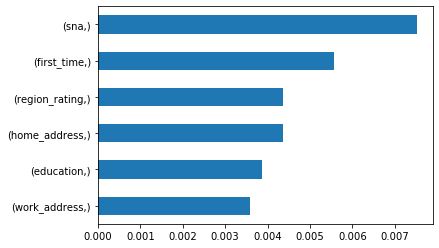

In [30]:
# Посмотрим значимость признаков
imp_cat = Series(mutual_info_classif(train_df[cat_cols], train_df['default'], 
                                     discrete_features=True), index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

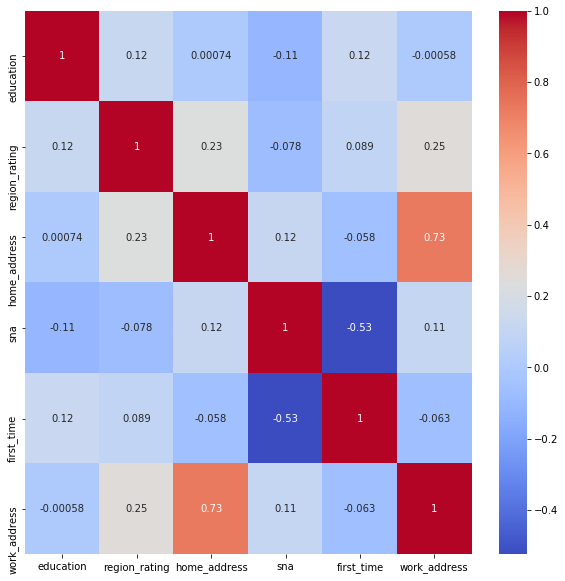

In [31]:
# Построим корреляционную матрицу
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_df[cat_cols].corr(), 
                 annot=True, cmap='coolwarm')

### Выводы по категориальным признакам:
1. sna и first_time являются самыми значимыми для целевой переменой, а сами эти признаки между собой имеют небольшую обратную корреляцию: то есть чем ближе связи клиентов банка, тем дольше мы знаем что-либо о клиенте. 
2. Корреляция же между домашним и рабочим адресами довольна сильная. Можно заметить, что для целевой переменной более значимым является признак домашнего адреса, поэтому в будущем можно попытаться избавиться от признака рабочего адреса.

## num_cols

Пройдёмся по числовым признакам, посмотрим на их распределение и возможное логарифмирование

#### 1. age

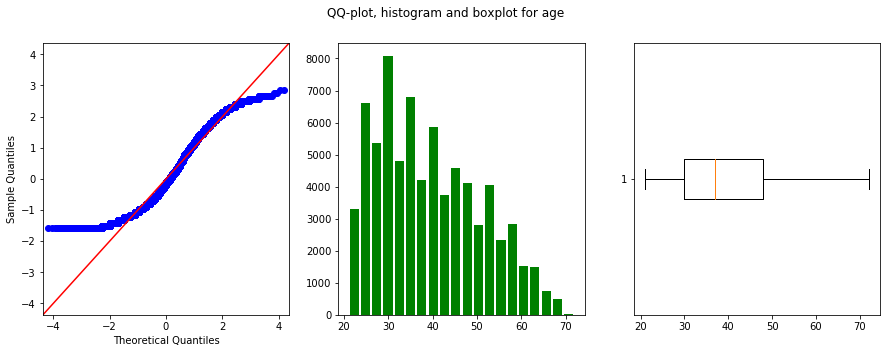

In [32]:
#1.1 Построим графики для age
data_age = NumFitInspect(data[data.Train == 1], 'age')
data_age.show_plots()

Признак распределён нормально, выбросов нет.

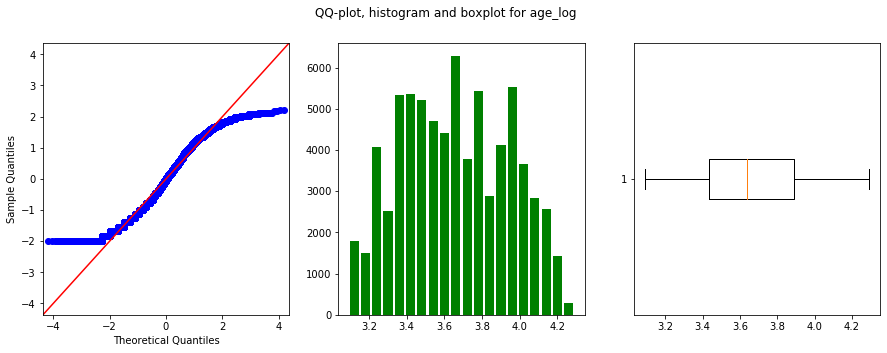

In [33]:
#1.2 Посмотрим на графики log(age) 
data_age.show_plots(log = True)

После логарифмирования признак age стал менее смещёнными.

In [34]:
# логарифмируем признак age
data['age'] = np.log(data['age'] + 1)
data['age'].sample(5)

42800    3.401197
80960    3.526361
7116     3.258097
87449    3.663562
8331     3.988984
Name: age, dtype: float64

**Заключение для age:** распределение нормальное, выбросов нет, взяли логарифм от признака.

#### 2. decline_app_cnt

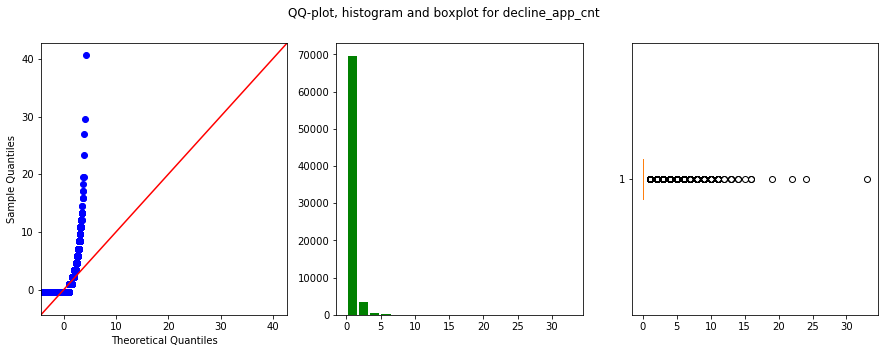

In [35]:
#2.1 Построим графики для decline_app_cnt
data_decline_app_cnt = NumFitInspect(data[data.Train == 1], 'decline_app_cnt')
data_decline_app_cnt.show_plots()

Мы наблюдаем сильное смещение. Применим логарифмирование и посмотрим, что получилось

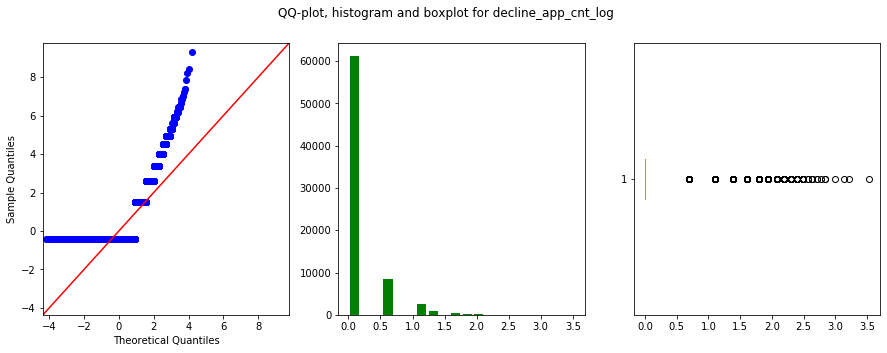

In [36]:
#2.2 Посмотрим на графики log(age)
data_decline_app_cnt.show_plots(log = True)

Очевидно, признак стал более нормальным.
Теперь посмотрим на выбросы.

In [37]:
print('Суммарное количество выбросов для decline_app_cnt: ', data_decline_app_cnt.outliers())
print('Суммарное количество выбросов для log(decline_app_cnt): ', data_decline_app_cnt.outliers(log = True))

Суммарное количество выбросов для decline_app_cnt:  12585
Суммарное количество выбросов для log(decline_app_cnt):  12585


In [38]:
data[data.decline_app_cnt < 2].decline_app_cnt.value_counts()

0    91471
1    12500
Name: decline_app_cnt, dtype: int64

In [39]:
# Создадим на основании decline_app_cnt новый бинарный признак: было(1) или не было(2) отказов.

data['decline_flag'] = data.decline_app_cnt.apply(lambda x: 0 if x < 1 else 1)
data['decline_flag'].value_counts()

0    91471
1    18677
Name: decline_flag, dtype: int64

In [40]:
new_fits = ['decline_flag']

In [41]:
# логарифмируем признак decline_app_cnt
data['decline_app_cnt'] = np.log(data['decline_app_cnt'] + 1)
data['decline_app_cnt'].sample(5)

34028    0.000000
44861    0.000000
52107    1.386294
37760    0.000000
84712    0.693147
Name: decline_app_cnt, dtype: float64

**Заключение по decline_app_cnt:** распределение нормальное, очень сильно смещенное (так, что даже логарифмирование не смогло исправить это в достаточной степени), взяли логарифм, выбросов очень много даже после логарифмирования, поэтому удалять их пока не стоит. Посмотрим влияение выбросов на модель в дальнейшем.
Был создан новый бинарный признак: был ли хоть один отказ или не было.

#### 3. income

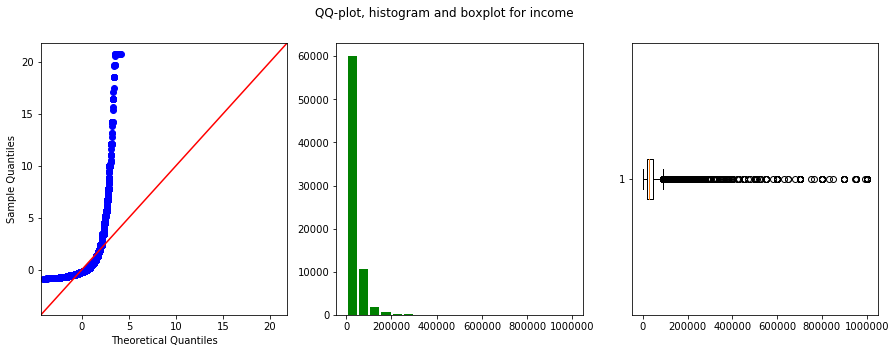

In [42]:
#3.1 Построим графики для income
data_income = NumFitInspect(data[data.Train == 1], 'income')
data_income.show_plots()

Признак очень смещен. Много выбросов.

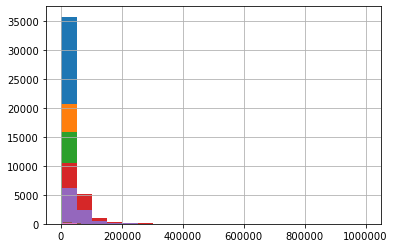

In [43]:
# Посмотрим на распределение признака в регионах
for x in data['region_rating'].value_counts().index:
    data['income'][data['region_rating'] == x].hist(bins=20)
plt.show()

Видим, что в регионах также наблюдается очень сильное смещение. Нормировать относительно региона не получится.

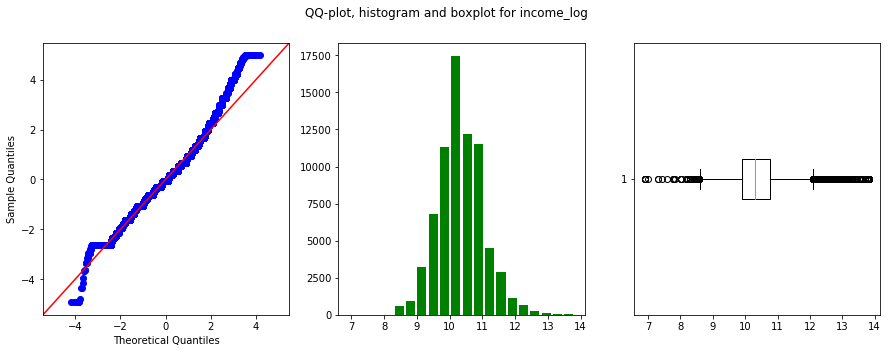

In [44]:
#3.2 Посмотрим на log(income)
data_income.show_plots(log = True)

После логарифмирования признак income стал гораздо более нормальным и менее смещёнными.
Теперь посмотрим на выбросы.

In [45]:
print('Суммарное количество выбросов для income: ', data_income.outliers())
print('Суммарное количество выбросов для log(income): ', data_income.outliers(log = True))

Суммарное количество выбросов для income:  4695
Суммарное количество выбросов для log(income):  1767


После логарифмирования количество выбросов значительно уменьшилось.

In [46]:
# логарифмируем признак income
data['income'] = np.log(data['income'] + 1)
data['income'].sample(5)

102605     9.472782
46637      8.853808
54057     10.308986
15341     10.308986
101464    11.289794
Name: income, dtype: float64

**Заключение по income:** распределение нормальное, взяли логарифм, количество выбросов после логарифмирования значительно уменьшилось, поэтому удалять их пока не будем. Посмотрим влияние выбросов на модель в дальнейшем.

#### 4. bki_request_cnt

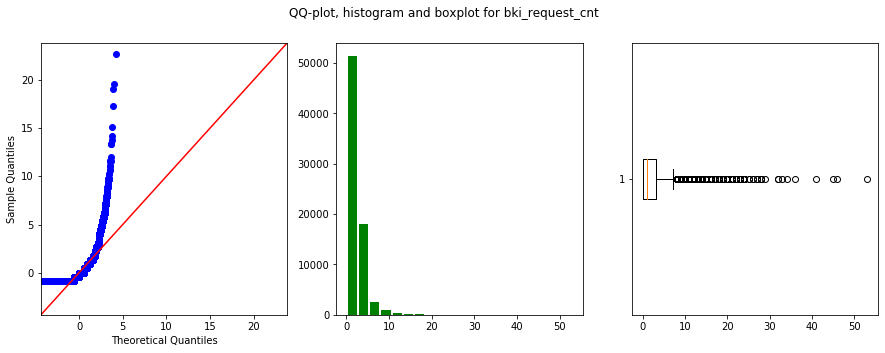

In [47]:
#4.1 Построим графики для bki_request_cnt
data_bki_request_cnt = NumFitInspect(data[data.Train == 1], 'bki_request_cnt')
data_bki_request_cnt.show_plots()

Признак очень смещен. Много выбросов.

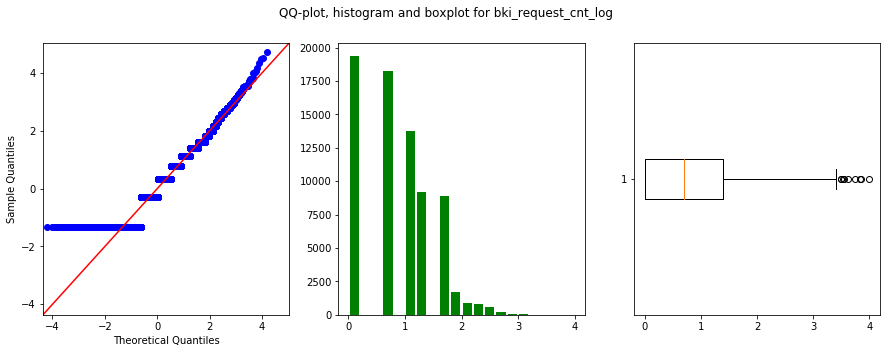

In [48]:
#4.2 Посмотрим на log(bki_request_cnt)
data_bki_request_cnt.show_plots(log = True)

Очевидно, признак стал более нормальным.
Теперь посмотрим на выбросы.

In [49]:
print('Суммарное количество выбросов для bki_request_cnt: ', data_bki_request_cnt.outliers())
print('Суммарное количество выбросов для log(bki_request_cnt): ', data_bki_request_cnt.outliers(log = True))

Суммарное количество выбросов для bki_request_cnt:  1755
Суммарное количество выбросов для log(bki_request_cnt):  9


Количество выбросов после логарифмирования существенно уменьшилось.

In [50]:
# логарифмируем признак bki_request_cnt
data['bki_request_cnt'] = np.log(data.bki_request_cnt + 1)
data['bki_request_cnt'].sample(5)

21478     1.386294
18554     1.098612
14096     0.693147
103480    0.693147
68446     0.000000
Name: bki_request_cnt, dtype: float64

**Заключение по bki_request_cnt:** распределение нормальное, взяли логарифм, количестов выбросов после логарифмирования существенно уменьшилось, не будем их удалять.

#### 5. score_bki

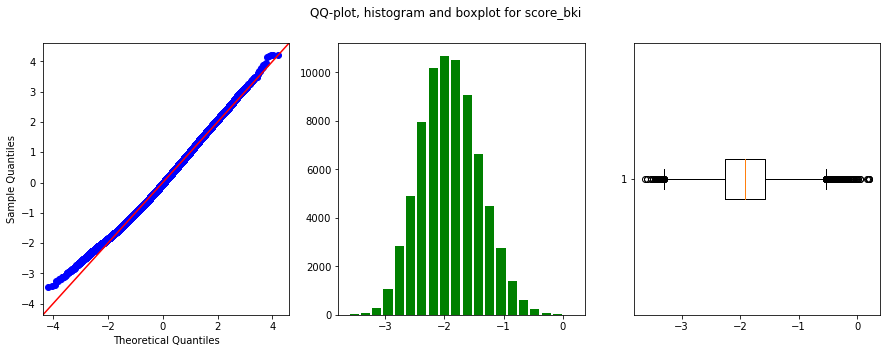

In [51]:
#5.1 Построим графики для score_bki
data_score_bki = NumFitInspect(data[data.Train == 1], 'score_bki')
data_score_bki.show_plots()

Распределение нормальное, не смещенное. Однако, есть выбросы.

In [52]:
print('Суммарное количество выбросов для score_bki: ', NumFitInspect(data[data.Train == 1], 'score_bki').outliers())

Суммарное количество выбросов для score_bki:  351


**Заключение по score_bki:** распределение нормальное, не смещенное, логарифм брать не надо, выбросов относительно не много, не будем их удалять. 

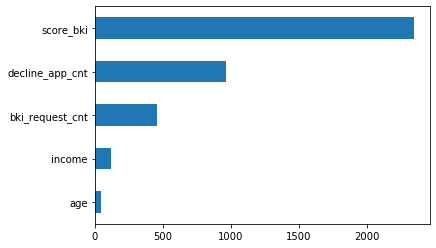

In [53]:
# Посмотрим значимость признаков
imp_num = Series(f_classif(train_df[num_cols], train_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

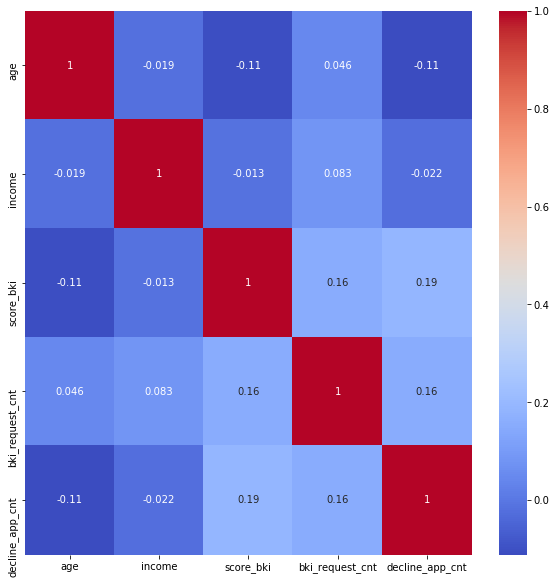

In [54]:
# Построим корреляционную матрицу
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_df[num_cols].corr(), 
                 annot=True, cmap='coolwarm')

Сильной корреляционной взаимосвязи между признаками не наблюдается. Наиболее значимым является признак score_bki, поэтому давайте посмотрим, какие признаки важны для него.

In [55]:
all_cols = cat_cols + num_cols + bin_cols
all_cols.extend(['default'])
all_cols.remove('score_bki')

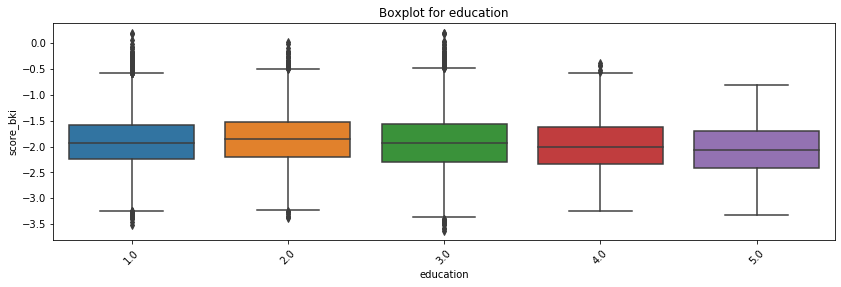

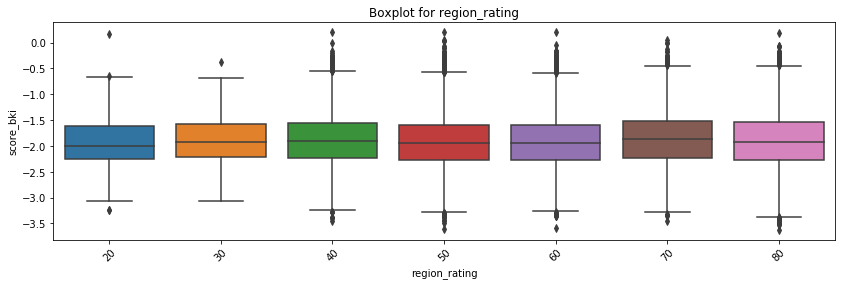

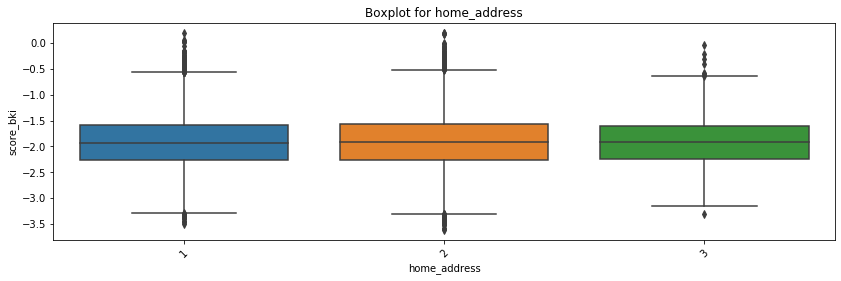

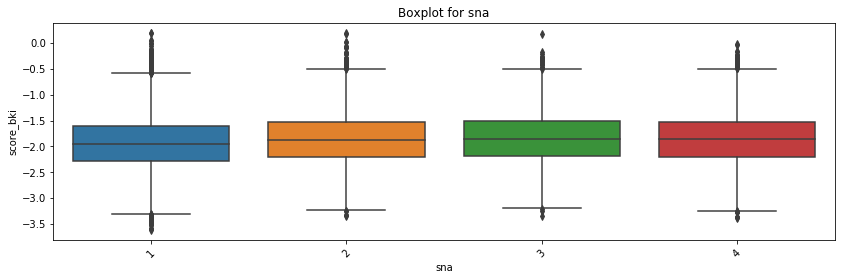

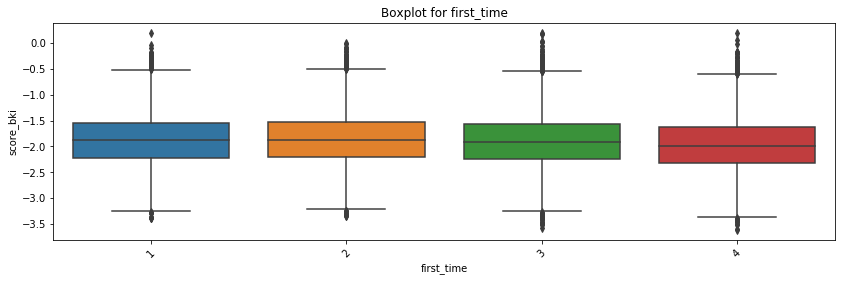

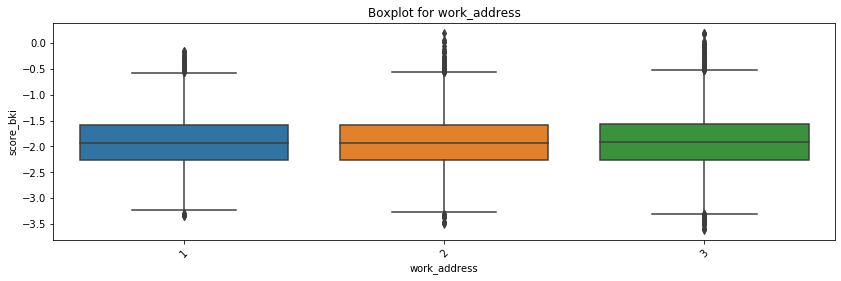

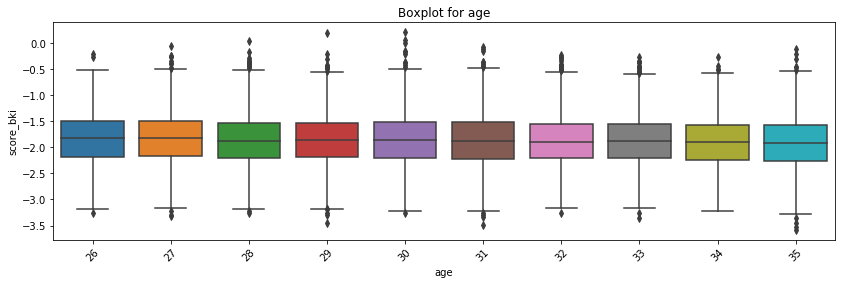

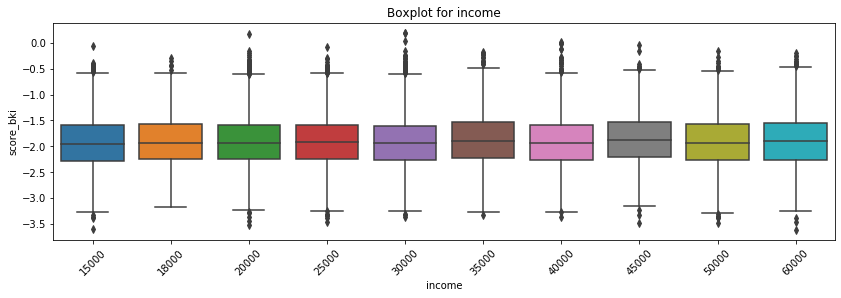

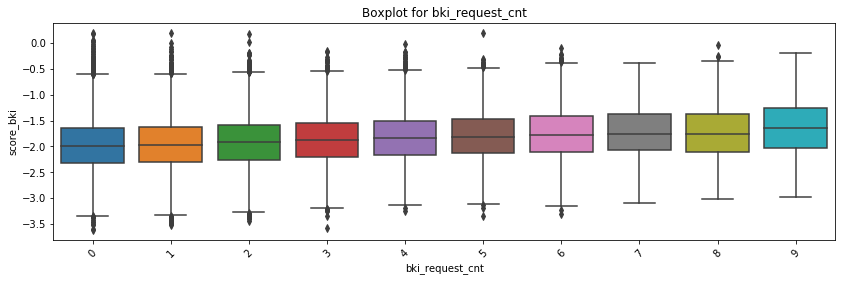

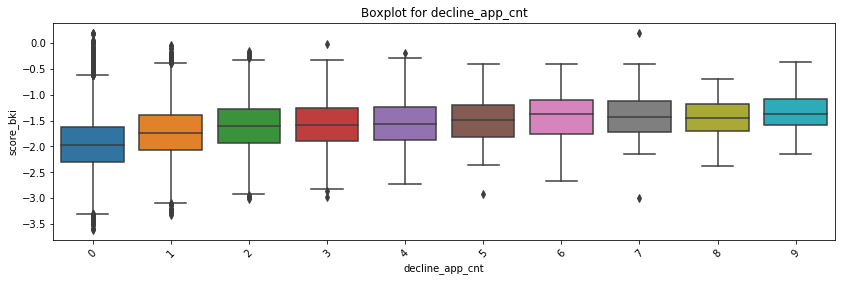

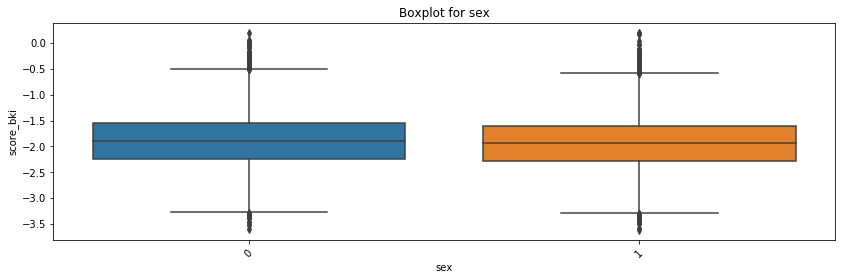

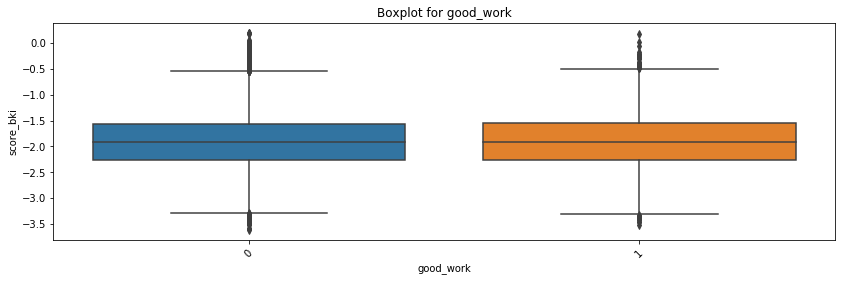

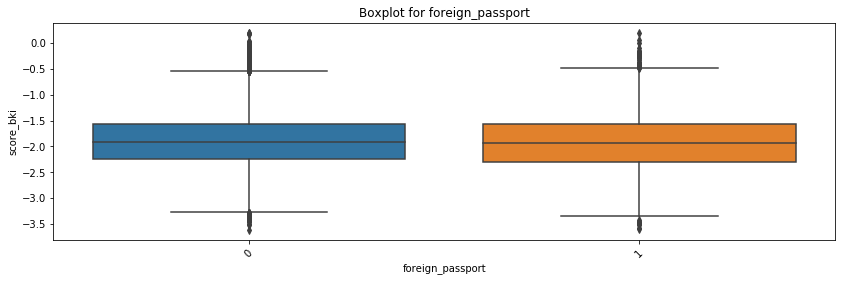

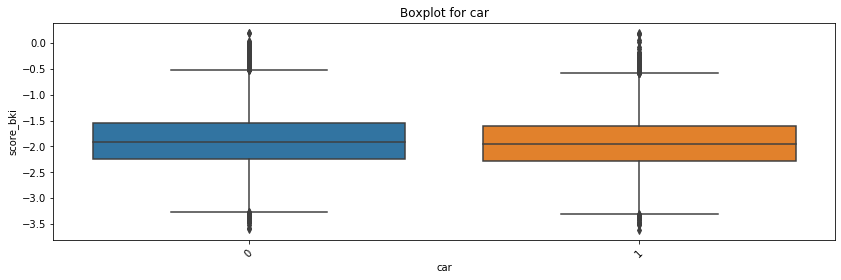

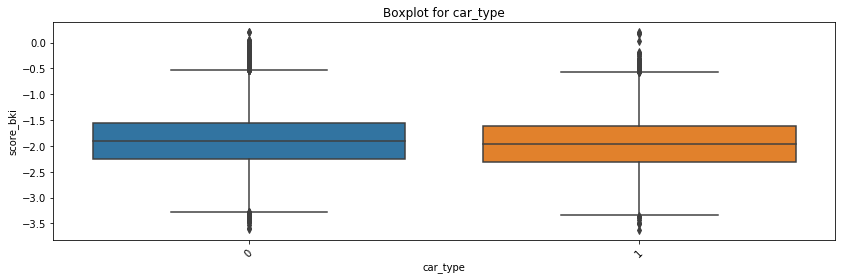

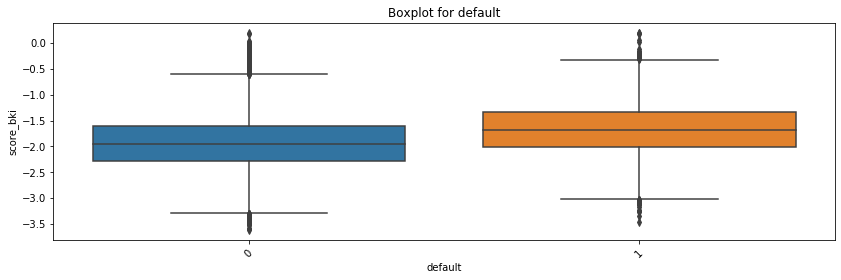

In [56]:
for column in all_cols:
    get_boxplot(train_df.loc[train_df.loc[:, column].isin(train_df.loc[:, column].value_counts().index[:10])], column)

Таким образом, визуально разницу в распределении можно отметить у следующих признаков: sna, decline_app_cnt, bki_request_cnt, car, car_type, education. Последние три указывают нам на уровень жизни и доходов заемщика.

### app_date

Остался еще один отдельно стоящий признак - дата подачи заявки. Давайте сразу преобразуем его и разделим на три составляющие: день, месяц, год.

In [57]:
train_df.app_date = pd.to_datetime(train_df.app_date)
train_df['app_day'] = train_df.app_date.dt.day
train_df['app_month'] = train_df.app_date.dt.month
train_df['app_year'] = train_df.app_date.dt.year

train_df.app_month.value_counts()

3    21178
2    18028
4    17683
1    16910
Name: app_month, dtype: int64

In [58]:
train_df.app_year.value_counts()

2014    73799
Name: app_year, dtype: int64

Итак, данные у нас только за 4 первых месяца 2014 года. Год удалим, этот признак для нас неинформативен, а день и месяц определим в категориальные переменные.

In [59]:
cat_cols.extend(['app_day', 'app_month'])

train_df = train_df.drop('app_year', axis='columns')

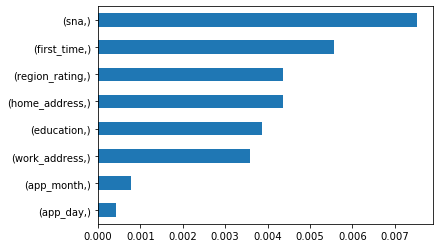

In [60]:
# Посмотрим значимость признаков
imp_cat = Series(mutual_info_classif(train_df[cat_cols], train_df['default'], 
                                     discrete_features=True), index=[cat_cols])
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

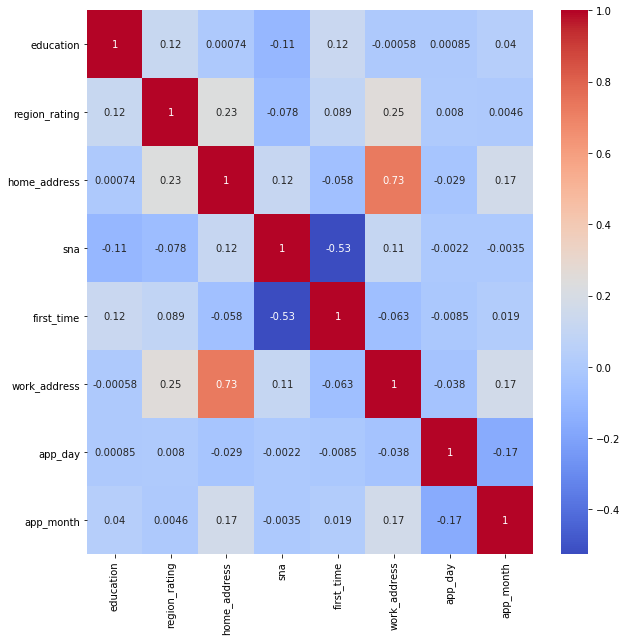

In [61]:
# Построим корреляционную матрицу
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(train_df[cat_cols].corr(), annot=True, cmap='coolwarm')

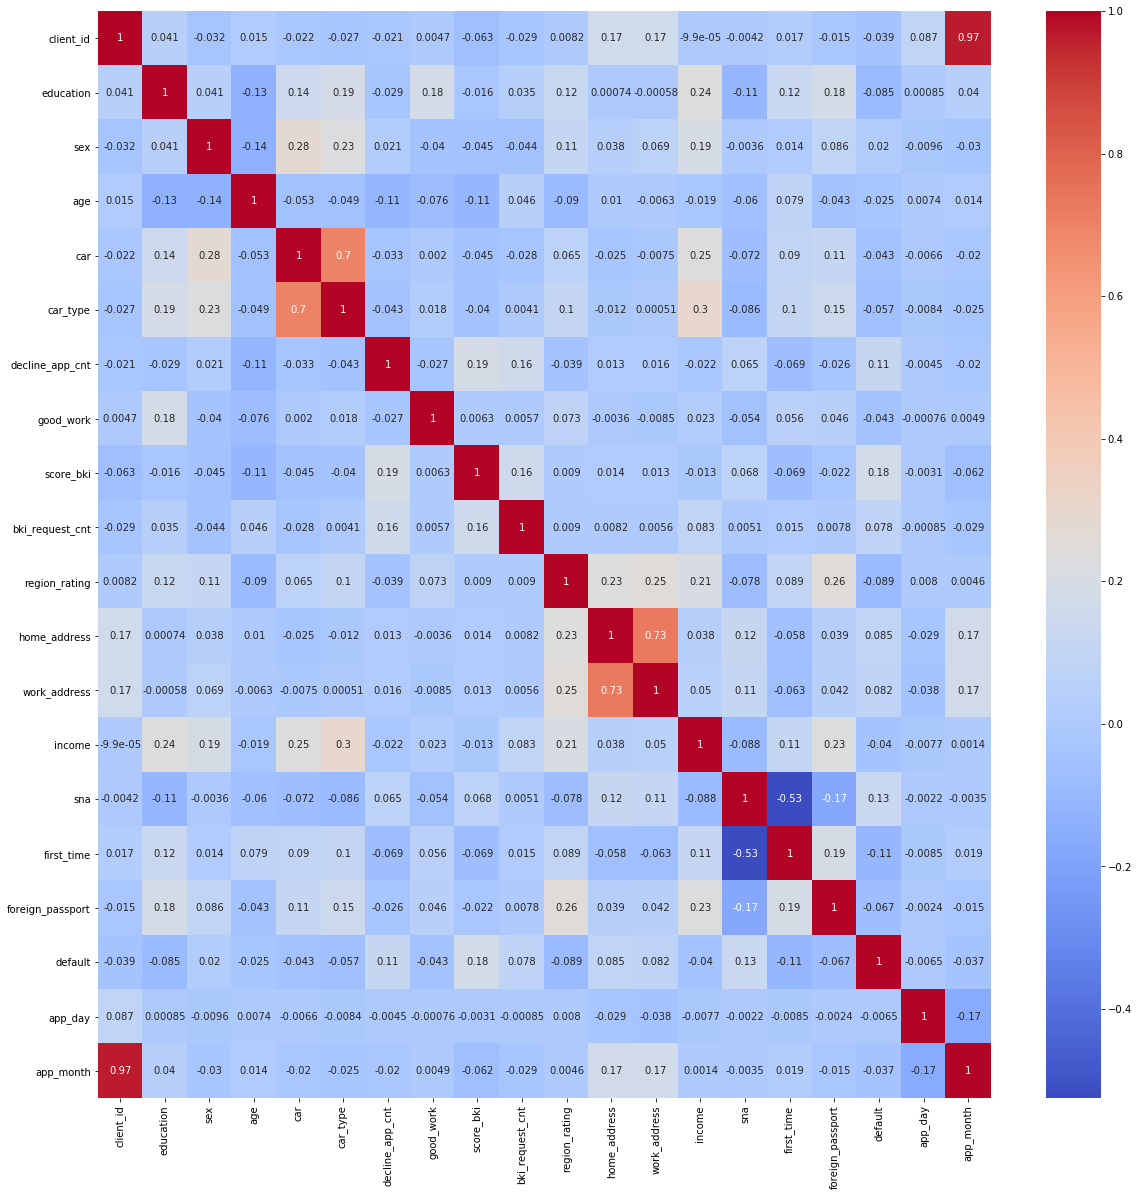

In [62]:
# Теперь давайте посмотрим на общую итоговую корреляционную матрицу
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax = sns.heatmap(train_df.drop(['Train'], axis=1).corr(), 
                 annot=True, cmap='coolwarm')

Как мы видим, между id клиента и месяцем присутствует очень большая корреляция, практически полная. Это неудивительно, если id банк присваивает порядковым номером. Мы также видим неболшую зависимости дохода от образования, наличия иномарки и заграничного паспорта, что объяснимо. Интересно, что признак sna, имеющий наибольшую (после score_bki) взаимосвязь с дефолтом, также взаимосвязан с адресом и наличием заграничного паспорта (помимо упомянутого ранее first_time). Конечно, зависимость, которую мы здесь видим, достаточно мала и опосредованна, так как речь о категориальных данных, а не числовых. Однако это дает нам возможности для формирования новых признаков для улучшения модели.

In [63]:
# избавимся пока от client_id
train_df = train_df.drop(['client_id'], axis='columns')

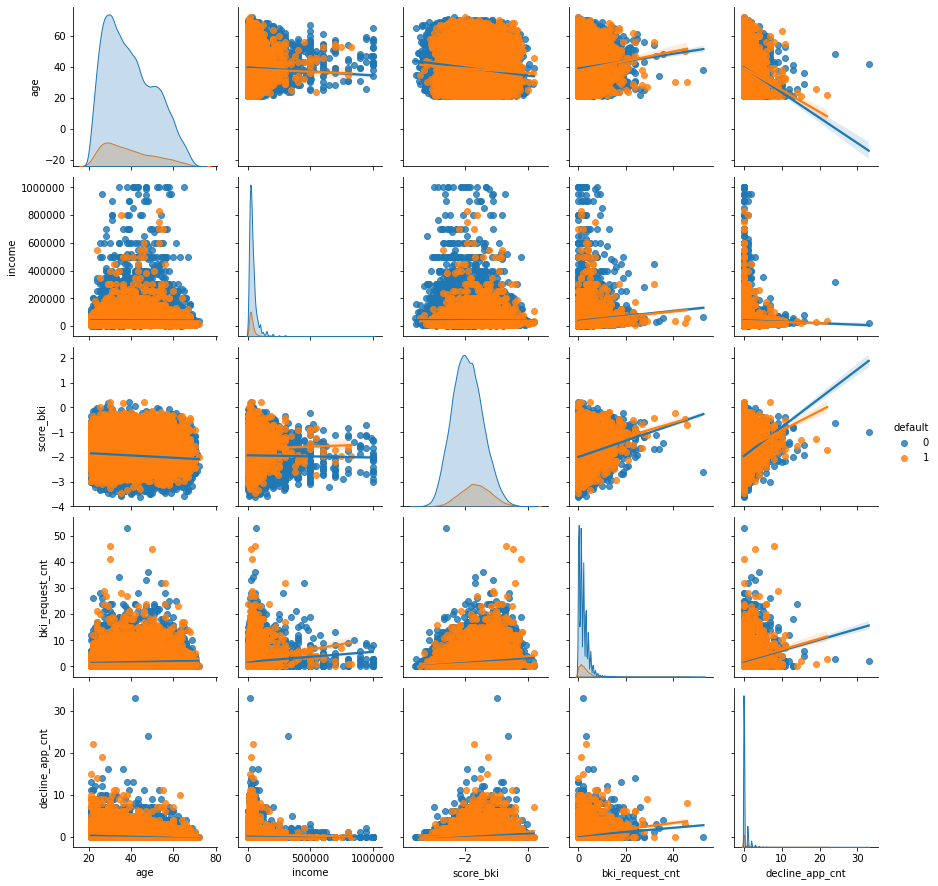

In [64]:
sns.pairplot(
    train_df.loc[:, [*num_cols, 'default']],
    hue='default',
    kind='reg'
)

In [65]:
nom_cols = cat_cols + bin_cols

for col in nom_cols:
    get_stat_dif(col, train_df)

Найдены статистически значимые различия для колонки education
Найдены статистически значимые различия для колонки region_rating
Найдены статистически значимые различия для колонки home_address
Найдены статистически значимые различия для колонки sna
Найдены статистически значимые различия для колонки first_time
Найдены статистически значимые различия для колонки work_address
Найдены статистически значимые различия для колонки app_month
Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки good_work
Найдены статистически значимые различия для колонки foreign_passport
Найдены статистически значимые различия для колонки car
Найдены статистически значимые различия для колонки car_type


In [66]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,Train,default,decline_flag
0,74835,22MAR2014,GRD,M,3.401197,Y,Y,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,N,0,NaN,0
1,17527,24JAN2014,SCH,F,3.688879,N,N,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,N,0,NaN,1
2,75683,23MAR2014,UGR,M,3.931826,Y,Y,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,Y,0,NaN,0
3,26883,03FEB2014,SCH,M,4.043051,N,N,0.000000,0,-2.374182,0.693147,40,1,2,9.741027,1,3,N,0,NaN,0
4,28862,04FEB2014,GRD,F,3.663562,N,N,0.000000,0,-2.487502,0.000000,80,2,3,11.695255,1,3,N,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,3.828641,N,N,0.000000,0,-1.792064,1.386294,50,1,2,9.741027,4,4,N,1,0.0,0
110144,76821,24MAR2014,SCH,M,3.737670,Y,Y,0.000000,0,-2.058029,0.693147,50,2,2,11.156265,1,4,N,1,0.0,0
110145,103695,22APR2014,SCH,M,3.465736,N,N,0.000000,0,-1.512635,1.609438,80,2,3,10.714440,2,2,N,1,0.0,0
110146,861,04JAN2014,SCH,F,3.401197,N,N,0.000000,1,-1.479334,1.386294,50,1,3,9.472782,2,3,N,1,1.0,0


## Выводы
1. Представленные выше графики построены для разведывательного анализа данных. Их построение стоит повторить после дополнительно обработки данных и введения новых признаков.
2. Чтобы отслеживать, насколько то или иное дальнейшее изменение полезно для модели, построим изначально наивную модель и посмотрим следующие метрики: **f1, precision, recall, roc auc, confusion matrix, balanced accuracy** (так как имеем дело с несбалансированными классами).
3. На основании проведенного выше анализа данных, предлагается далее провести эксперименты с данными (обработка и создание новых признаков), опираясь на изменения в метриках модели.
4. После проведенных изменений и дополнений также следует оценить значимость признаков и избавиться от лишнего, после чего обработать объединенный датасет на основании полученных результатов.

### Дополнительно:
- поработать с несбалансированностью классов
- построить модели с учетом подбора гиперпараметров и отбором признаков

# Naive model

In [67]:
train_df.sample(5)

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,app_day,app_month
23147,2014-03-04,3.0,0,32,0,0,1,0,-1.414405,1,40,3,2,40000,3,3,0,1,1,4,3
56293,2014-04-19,3.0,0,47,1,0,0,1,-2.760446,0,80,2,3,60000,1,4,0,0,1,19,4
54591,2014-03-06,3.0,0,39,0,0,0,0,-1.852070,1,50,1,2,15000,1,4,0,0,1,6,3
47323,2014-02-04,1.0,0,37,0,0,0,0,-1.181057,7,50,2,3,20000,1,2,0,0,1,4,2
32012,2014-03-31,3.0,0,41,1,1,0,0,-1.929888,3,70,2,3,60000,1,4,0,0,1,31,3


In [68]:
X = train_df.drop(['Train', 'default', 'app_date'], axis='columns')
y = train_df['default'].values

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

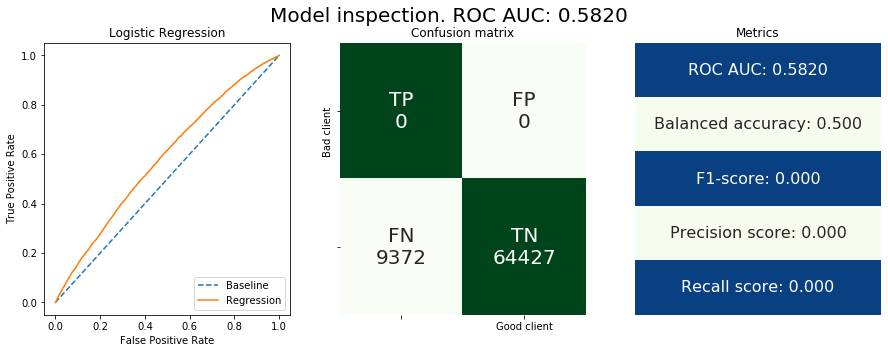

In [70]:
get_model(X, y)

Из обработок, которые мы провели уже перед построением модели можно выделить только: заполение менее 1% пропусков в признаке 'education', выделение признаков день и месяц из признака даты. Удаление признака id. Задача модели - верно идентифицировать дефолтных клиентов. Поэтому самый показательной для нас является - confusion matrix, по которой мы точно видим, как произошло распределение клиентов по классам. TP - верно определенные дефолтные клиенты, FP - ошибочно определенные дефолтные клиенты, FN - ошибочно определенные недефолтные клиенты и TN - верно определенные недефолтные клиенты. Пока мы видим, что модель работает плохо, пока это просто игра в угадайку 50/50 и всех клиентов она просто помещает в классы по общей пропорции 1 к 7.

## Feature engineering & Prepping data for model

### Проведенные эксперименты
В рамках дальнейшей работы было проведено большое количество экспериментов для оценки эффективности вносимых изменений для модели. В итоговом коде файла пошаговые эксперименты не отображены в целях экономии пространства и удобства восприятия. Проделаны следующие шаги:

- на основе признака app_date были проведены следующие эксперименты: введен бинарный признак выходного дня, введен бинарный признак дня месяца (начало/конец месяца)
- введен категориальный признак, объединяющий car и car_type
- создан бинарный признак наличия высшего образования
- были логарифмированы числовые признаки (за исключением score_bki)
- были проведены эксперименты с удалением и сглаживанием выбросов числовых переменных
- score_bki было переведено в положительные значения
- добавлен новый признак на основе sna, foreign_passport, address
- категориальные переменные переведены в dummy-переменные (был произведен экспериментальный отбор признаков, значимых при переводе в dummy-переменную)
После проведения всех преобразований, был проведен анализ значимости признаков и отобраны те, которые приносили больше пользы на для модели. Финально на шаге подготовки данных все преобразования (за исключением откровенно неудачных, которые не отражены в коде ниже), были собраны для построения модели.

In [71]:
df_exp = train_df.drop(['Train', 'default'], axis='columns')

# признаки на основе даты
df_exp['weekend'] = df_exp['app_date'].dt.weekday
df_exp['weekend'] = df_exp['weekend'].apply(lambda x: 1 if x >= 5 else 0)
df_exp['app_day_bin'] = df_exp['app_day'].apply(lambda x: 1 if x <= 15 else 0)

df_exp['car+type'] = df_exp['car'] + train_df['car_type']                              # car + type
df_exp['is_high_edu'] = df_exp['education'].apply(lambda x: 1 if x >= 3 else 0)        # бинарный признак образования

df_exp['bki_request_cat'] = df_exp['bki_request_cnt'].apply(lambda x: 3 if x >= 3 else x)   # категориальный признак запросов
df_exp['income_cat'] = df_exp['income'].apply(lambda x: 1 if x < 30000 else 2 if x < 50000 else 3 if x < 100000 else 4)  # категориальный признак дохода
df_exp['decline_cat'] = df_exp['decline_app_cnt'].apply(lambda x: 2 if x >= 2 else x)      # категориальный признак отказов

# Новые категориальные признаки на основе имеющихся
df_exp['sna_add_pass'] = df_exp['sna'] + (df_exp['home_address']**2) + (3*df_exp['foreign_passport']) 
df_exp['popular_age'] = df_exp['age'].apply(lambda x: 0 if x < 30 else 2 if x > 50 else 1)

# Преобразование категориальных признаков в get_dummies (ручной подбор)
df_exp = pd.get_dummies(df_exp, columns=['education', 'region_rating', 'home_address', 'sna', 'work_address',
                                        'app_month', 'bki_request_cat', 'sna_add_pass', 'popular_age',
                                        'decline_cat', 'first_time'])

# Логарифмирование
df_exp[['age', 'income', 'bki_request_cnt', 'decline_app_cnt']] = np.log(df_exp[['age', 'income', 'bki_request_cnt', 'decline_app_cnt']] + 1)

# Удаление неважных признаков (ручной подбор)
df_exp = df_exp.drop(['car', 'decline_app_cnt', 'foreign_passport', 'weekend', 'app_day_bin',
                     'education_1.0', 'education_2.0', 'education_3.0', 'region_rating_20',
                     'region_rating_30', 'region_rating_40', 'home_address_1', 'home_address_3',
                     'sna_4', 'work_address_2', 'bki_request_cat_0', 'bki_request_cat_2',
                     'sna_add_pass_2', 'sna_add_pass_10', 'sna_add_pass_14', 'sna_add_pass_15',
                     'sna_add_pass_16', 'popular_age_0', 'decline_cat_0', 'first_time_1', 'app_date'], axis='columns')

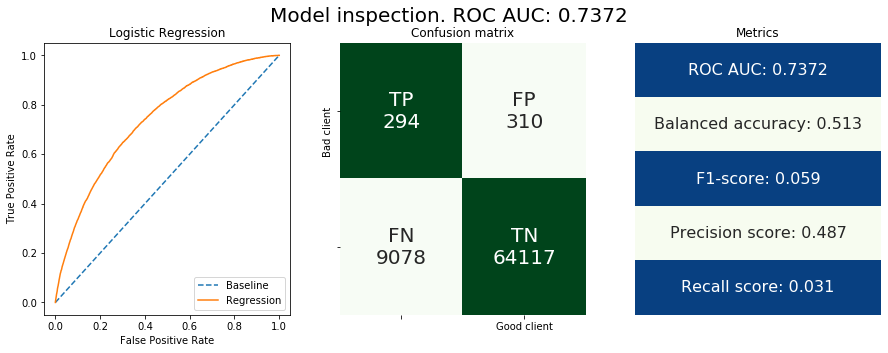

In [72]:
# Нормализуем данные, разделим на трейн и тест и обучим модель. Посмотрим получившиеся метрики.

df_exp = scaler_st.fit_transform(df_exp)

X = df_exp
y = train_df['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

get_model(X, y)

#### Выводы:
Итак, мы видим, что осуществленные преобразования сильно улучшили качество модели, однако метрика recall остается очень низкой, всего 3%, из-за чего и f1 также низкий, несмотря на неплохой precision. По матрице мы видим, что модель все равно не очень хорошо определяет дефолтных клиентов, что может грозить банку потерей выгоды.
Некоторые из преобразований, которые я осуществила, либо ухудшали качество модели, либо никак ей не помогали, поэтому на финальном шаге удаления признаков от них было принято решение отказаться. 
Главной проблемой является несбалансированность классов, поэтому над ней стоит поработать и попробовать применить несколько методов балансировки.
Также стоит обратить внимание на пропорции классов при разделении выборки на обучающую и тестовую. Сильные различия в выборках могут показывать некорректные результаты для оценки.
В конце необходимо осуществить подбор гиперпараметров и проверить модель на возможное переобучение.

## Несбалансированность классов
В нашей выборке классы представлены в пропорции 1 к 7. Попробуем восстановить баланс классов с помощью двух методов: undersampling совместно в oversampling.

In [73]:
# undersampling

und_sampler = RandomUnderSampler(random_state=42)

X_und, y_und = und_sampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_und, y_und, test_size=0.20, random_state=42)

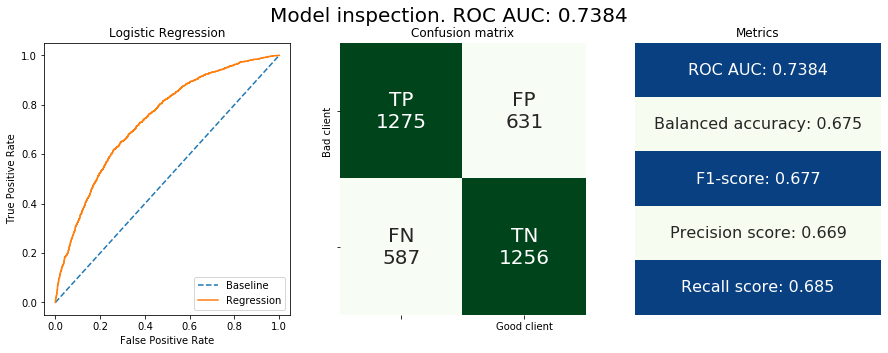

In [74]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

ModelInspector(model, X_test, y_test).inspect()

In [75]:
# Попробуем undersampling и oversampling

over = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

X_new, y_new = over.fit_resample(X, y)
X_res, y_res = under.fit_resample(X_new, y_new)

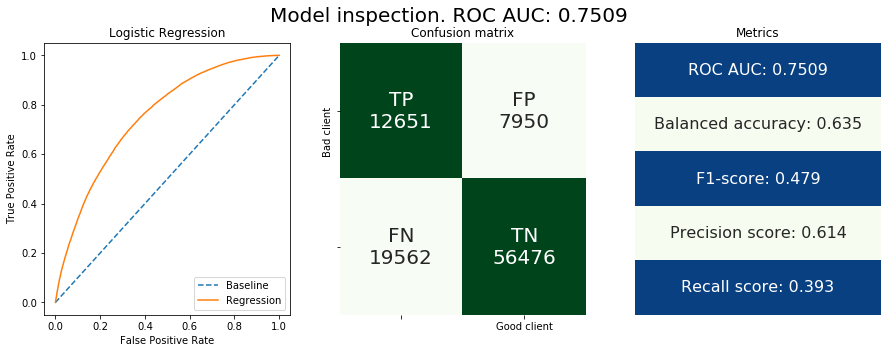

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

get_model(X_res, y_res)

Итак, как мы видим, балансировка выборки дает отличные результаты. Причем, двойной метод сначала синтетического oversampling, а затем undersampling - лучше, чем просто undersampling, но только для метрики соревнования - roc auc. Лучше модель все же работает только на undersampling, или только на oversampling.

In [77]:
# Oсуществим подбор гиперпараметров при undersampling

X_train, X_test, y_train, y_test = train_test_split(X_und, y_und, test_size=0.20, random_state=42)

In [78]:
def find_best_params(X_train, y_train):
    '''Функция для нахождения лучших гиперпараметров для модели.'''
    
    # Добавим типы регуляризации
    penalty = ['l1', 'l2', 'elasticnet']

    # Зададим ограничения для параметра регуляризации
    C = np.logspace(0, 4, 10)

    # Создадим гиперпараметры
    hyperparameters = dict(C=C, penalty=penalty)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    best_model = clf.fit(X_train, y_train)

    # Посмотримн на лучшие гиперпараметры
    best_params = best_model.best_estimator_.get_params()
    print('Лучшее Penalty:', best_params['penalty'])
    print('Лучшее C:', best_params['C'])
    print('Лучший solver:', best_params['solver'])
    
    return best_params['penalty'], best_params['C'], best_params['solver']

LogisticRegression(C=1, penalty='l1', solver='liblinear')

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [79]:
# Подберем лучшие параметры для модели.

penalty, C, solver = find_best_params(X_train, y_train)

Лучшее Penalty: l2
Лучшее C: 1.0
Лучший solver: lbfgs


### Построим модель с подобранными гиперпараметрами и посмотрим на результат по метрикам.

In [80]:
model = LogisticRegression(penalty=penalty, C=C, solver=solver, class_weight = 'balanced', max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

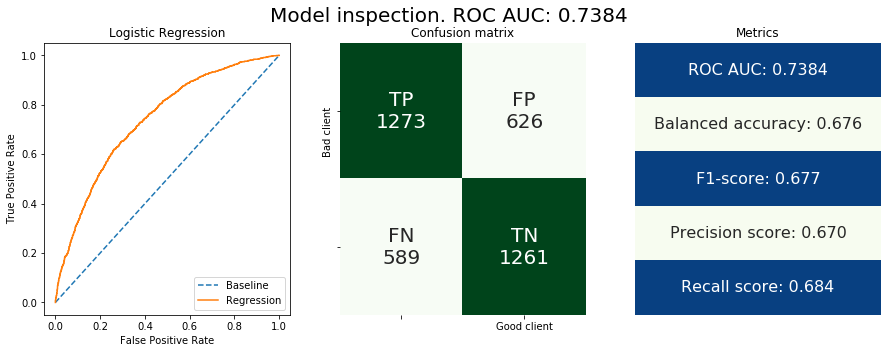

In [81]:
ModelInspector(model, X_test, y_test).inspect()

С учетом небольшого количества имеющихся данных (всего 4 месяца наблюдений) вышел довольно неплохой результат: метрики значительно подросли, судя по confusion matrix модель начала неплохо определять классы.

In [90]:
class CreditScoringProcessor():
    def __init__(self, df):
        self.df = df
        self.model = None

        self.label_encoder = LabelEncoder()
        self.scaler_st = StandardScaler()

    def _prepare_dataframe(self, df):
        df_exp = df.copy()

        bin_cols = ['sex', 'good_work', 'foreign_passport',
                    'car', 'car_type', 'is_high_edu', 'car+type']
        
        # prepping data / feature engineering
        edu = {'SCH': 1, 'UGR': 2, 'GRD': 3, 'PGR': 4, 'ACD': 5}
        df_exp['education'] = df_exp['education'].map(edu)
        df_exp['education'].fillna(1, inplace=True)

        df_exp['app_date'] = pd.to_datetime(df_exp['app_date'])
        df_exp['app_day'] = df_exp['app_date'].dt.day
        df_exp['app_month'] = df_exp['app_date'].dt.month

        df_exp['car+type'] = df_exp['car'] + df_exp['car_type']
        df_exp['is_high_edu'] = df_exp['education'].apply(
            lambda x: 1 if x >= 3 else 0)

        for column in bin_cols:
            df_exp[column] = self.label_encoder.fit_transform(df_exp[column])

        df_exp['bki_request_cat'] = df_exp['bki_request_cnt'].apply(
            lambda x: 3 if x >= 3 else x)
        df_exp['income_cat'] = df_exp['income'].apply(
            lambda x: 1 if x < 30000 else 2 if x < 50000 else 3 if x < 100000 else 4)
        df_exp['decline_cat'] = df_exp['decline_app_cnt'].apply(
            lambda x: 2 if x >= 2 else x)
        df_exp['sna_add_pass'] = df_exp['sna'] + \
            (df_exp['home_address']**2) + (3*df_exp['foreign_passport'])
        df_exp['popular_age'] = df_exp['age'].apply(
            lambda x: 0 if x < 30 else 2 if x > 50 else 1)

        df_exp = pd.get_dummies(df_exp, columns=[
            'education', 'region_rating', 'home_address', 'sna', 'work_address',
            'app_month', 'bki_request_cat', 'sna_add_pass', 'popular_age',
            'decline_cat', 'first_time'])

        df_exp[['age', 'income', 'bki_request_cnt', 'decline_app_cnt']] = np.log(
            df_exp[['age', 'income', 'bki_request_cnt', 'decline_app_cnt']] + 1)

        # удалим лишнее
        df_exp.drop(columns=['car', 'decline_app_cnt', 'foreign_passport', 'education_1.0', 'education_2.0', 
                             'education_3.0', 'region_rating_20', 'region_rating_30', 'region_rating_40', 
                             'home_address_1', 'home_address_3', 'sna_4', 'work_address_2', 'bki_request_cat_0', 
                             'bki_request_cat_2', 'sna_add_pass_2', 'sna_add_pass_10', 'sna_add_pass_14', 
                             'sna_add_pass_15', 'sna_add_pass_16', 'popular_age_0',  'decline_cat_0', 'first_time_1', 
                             'app_date', 'default'], inplace=True)
                
        # подготовим ответы
        y_train = df.query('Train == 1')['default'].values
        
        # Подготовим тренировочные данные
        X_train = df_exp.query('Train == 1').drop(columns=['Train', 'client_id'])

        # Обучим стандартизатор фич (нужен будет для тестовых данных так-же)
        self.scaler_st.fit(X_train)

        X_train = self.scaler_st.transform(X_train)

        # Оставляем client_id в продакшн данных, так как он понадобится в финальном ответе
        self.X_test = df_exp.query('Train == 0').drop(columns=['Train'])

        return X_train, y_train

    def _process_undersampling(self, X, y):
        return RandomUnderSampler(random_state=42).fit_resample(X, y)


    def _find_best_hiperparams(self, X_train, y_train):
        # Добавим типы регуляризации
        penalty = ['l1', 'l2']

        # Зададим ограничения для параметра регуляризации
        C = np.logspace(0, 4, 10)

        # Создадим гиперпараметры
        hyperparameters = dict(C=C, penalty=penalty)

        model = LogisticRegression()
        model.fit(X_train, y_train)

        # Создаем сетку поиска с использованием 5-кратной перекрестной проверки
        clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

        best_model = clf.fit(X_train, y_train)
        best_params = best_model.best_estimator_.get_params()

        return best_params

    def train_model(self):
        # подготовим датафрэйм, почистим его, добавим новые фичи, удалим незначимые
        X, y = self._prepare_dataframe(self.df)

        # выполним балансировку датафрэйма
        X_res, y_res = self._process_undersampling(X, y)

        # выполним разделение тренировочной и тестовой выборки
        X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

        # найдем наилучшие гипер-параметры
        best_params = self._find_best_hiperparams(X_train, y_train)

        # создадим и обучим модель
        self.model = LogisticRegression(
            penalty=best_params['penalty'],
            C=best_params['C'],
            solver=best_params['solver'],
            class_weight='balanced',
            max_iter=100,
            random_state=42
        )

        self.model.fit(X_train, y_train)

        # отобразим результат
        ModelInspector(self.model, X_test, y_test).inspect()
    
    def plot_cross_val_score(self):
        if self.model is None:
            raise NotImplementedError(
                'Модель не тренированна! Сначала выполните тренировку модели!')

        # подготовим датафрэйм, почистим его, добавим новые фичи, удалим незначимые
        X, y = self._prepare_dataframe(self.df)

        # выполним балансировку датафрэйма
        X_res, y_res = self._process_undersampling(X, y)

        # выполним разделение тренировочной и тестовой выборки
        X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.20, random_state=42)

        # посчитаем метрику F1 для 30 фолдов.
        train_score = cross_val_score(self.model, X_train, y_train, cv=30, scoring='f1')
        test_score = cross_val_score(self.model, X_test, y_test, cv=30, scoring='f1')

        avg_f1_train, std_f1_train = train_score.mean(), train_score.std()
        avg_f1_test, std_f1_test = test_score.mean(), test_score.std()
        
        plt.figure(figsize=(15, 8))

        plt.plot(train_score, label=f'[Train] F1-score: {avg_f1_train:.2f} $\pm$ {std_f1_train:.2f}', marker='.')
        plt.plot(test_score, label=f'[Test] F1-score: {avg_f1_test:.2f} $\pm$ {std_f1_test:.2f}', marker='.')

        plt.ylim([0.2, 1.]);
        plt.xlabel('CV iteration', fontsize=15)
        plt.ylabel('F1-score', fontsize=15)
        plt.legend(fontsize=15)

    def predict(self):
        if self.model is None:
            raise NotImplementedError(
                'Модель не тренированна! Сначала выполните тренировку модели!')

        client_ids = self.X_test['client_id']
        X_test = self.X_test.drop(columns=['client_id'])        
        
        X_test = self.scaler_st.transform(X_test)
        
        probs = self.model.predict_proba(X_test)[:, 1]

        return pd.concat([client_ids, pd.Series(probs, name='default')], axis=1)

In [91]:
# Объединим наши датасеты и запустим класс.

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df['Train'] = 1 # помечаем где у нас трейн
test_df['Train'] = 0 # помечаем где у нас тест

data = test_df.append(train_df, sort=False).reset_index(drop=True) # объединяем

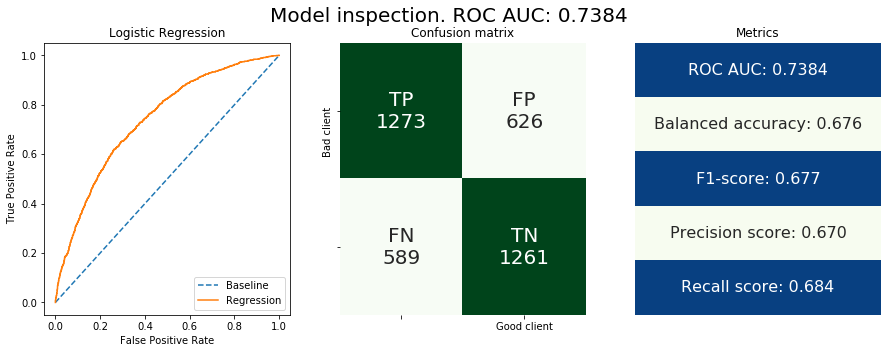

In [92]:
processor = CreditScoringProcessor(data)
processor.train_model()

## Проверим модель на переобучение

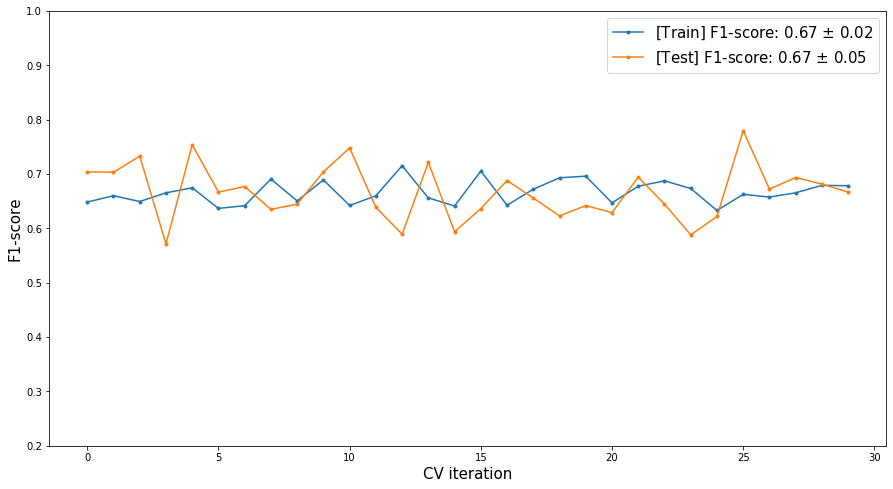

In [93]:
processor.plot_cross_val_score()

Кросс-валидация показывает низкую разницу между тренировочными результатами и тестовыми. Переобучения нет.

## Итог:
В результате работы над данными:

- был произведен разведывательный анализ данных
- созданы новые признаки
- отбраны признаки для модели по значимости
- произведена балансировка классов с помощью undersampling
- подобраны оптимальные гиперпараметры для модели
- проведена проверка модели на переобучение - результат отрицательный

В ходе улучшения качества модели на тестовой выборке были достигнуты следующие показатели:

- ROC AUC - 0.7384
- Balanced accuracy - 0.676
- F1-score - 0.677
- Precision score - 0.670
- Recall score - 0.684
- TP - 1273
- FP - 626
- FN - 589
- TN - 1261